In [1]:
#author Damir Pavlin, 2018 Moscow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


In [2]:
stockNames = ['EBAY', 'F', 'GE', 'INTC', 'JNJ', 'MSFT', 'NKE', 'XOM' ] #лист с именами эмитентов
closeVector = {} #пустой словарь для векторов котировок эмитентов
logYield = {} #пустой словарь для лог.доходностей эмитентов
weightStocks= {} #пустой словарь для весов

In [10]:
def MarkowitzPavlin(year, weightPreviousStocks): #для первой итерации предыдущую доходость надо ставить 0

    dt = 252 #число торговых дней в году
    stockNames = ['EBAY', 'F', 'GE', 'INTC', 'JNJ', 'MSFT', 'NKE', 'XOM' ] #лист с именами эмитентов
    closeVector = {} #пустой словарь для векторов котировок эмитентов
    logYield = {} #пустой словарь для лог.доходностей эмитентов
    weightStocks= {} #пустой словарь для весов



    for i in range(len(stockNames)): #цикл по проверке Nand и составлению векторов котировок
        frame = pd.read_csv(stockNames[i] + ".csv", header = 0, sep = ',')
        close = frame['Close']
        logProf = []
        k = 0
        for j in range (len(close)): #проверка на наличие нанов
            if type(close[j]) == np.float64: #TODO сделать очистку данных в случае Nanov
                k += 1
            else:
                print ("Начальник у нас Nan, возможно строка! Эмитент ", stockNames[i], " строка ", j, ", значени: ", close[j])

        weightStocks[stockNames[i]]=0 #задание пустых весов

        logProf.append(0.1)
        for m in range (len(close)-1): #заполнение вектора логдоходности
            logProf.append(np.log(close[m+1]/close[m]))

        closeVector[stockNames[i]] = close #составление векторов котировок
        logYield[stockNames[i]] = logProf #составление векторов логдоходностей

        #print ("Эмитент: ", stockNames[i], " всего строк: ", k, "cтрок в лог.дох: ", len(logProf) )

    #print (closeVector)

    covDoubleArray = [] #задание пустой матрицы ковариаций 
    covDoubleArray.append([])
    covDoubleArray[0].append(0)
    for i in range(len(stockNames)):
        covDoubleArray[0].append(stockNames[i])

    for i in range(1, len(stockNames)+1):
        covDoubleArray.append([])
        covDoubleArray[i].append(stockNames[i-1])
        for j in range(1, len(stockNames)+1):
            covDoubleArray[i].append(0)

    corDoubleArray = [] #задание пустой матрицы корреляций
    corDoubleArray.append([])
    corDoubleArray[0].append(0)
    for i in range(len(stockNames)):
        corDoubleArray[0].append(stockNames[i])

    for i in range(1, len(stockNames)+1):
        corDoubleArray.append([])
        corDoubleArray[i].append(stockNames[i-1])
        for j in range(1, len(stockNames)+1):
            corDoubleArray[i].append(0)




    #print(covDoubleArray)    


    #year = 2003 #год портфеля
    n = year-2003

    middleYield = {} #пустой словарь для средних год.лог.доходностей
    stDev = {} #пустой словарь для стандартного отклонения

    #print ("Средние годовые доходности и риск за ", year, " год:\n")
    for i in range(len(stockNames)):
        middleYield[stockNames[i]] = np.average(logYield[stockNames[i]][dt*n : dt + dt*n]) #средняя год.лог.доходность
        stDev[stockNames[i]] = np.std(logYield[stockNames[i]][dt*n : dt + dt*n]) #станд.откл., он же риск

        #TODO отформатировать вывод
        #print(stockNames[i], " доходность : ", middleYield[stockNames[i]], " ; риск : ",  stDev[stockNames[i]])

    maxCov = [0, '', ''] #КОВАРИАЦИИ
    for i in range(1, len(stockNames) + 1):
        for j in range(1, len(stockNames) + 1):
            covDoubleArray[i][j] = round(np.cov(logYield[stockNames[i-1]][dt*n : dt + dt*n], logYield[stockNames[j-1]][dt*n : dt + dt*n])[0][1],7)
            if stockNames[i-1] == stockNames[j-1]:
                covDoubleArray[i][j] = '' #вышибаем диагональ
            else:
                if covDoubleArray[i][j] > maxCov[0]: #вычисляем наиболее зависимые инструменты
                    maxCov[0] = covDoubleArray[i][j]
                    maxCov[1] = stockNames[j-1]
                    maxCov[2] = stockNames[i-1]

    dfCov = pd.DataFrame(covDoubleArray) #таблица пандас с ковариациями
    print ("\n\nГод: ", year)
    print ("Наиболее зависимые бумаги ", maxCov[1], " и ", maxCov[2], ", ковариация: ", maxCov[0])
    print ("Матрица ковариаций")
    display (dfCov)

    maxCor = [0, '', ''] #КОРРЕЛЯЦИИ
    for i in range(1, len(stockNames) + 1):
        for j in range(1, len(stockNames) + 1):
            corDoubleArray[i][j] = round(np.corrcoef(logYield[stockNames[i-1]][dt*n : dt + dt*n], logYield[stockNames[j-1]][dt*n : dt + dt*n])[0][1],6)
            #if stockNames[i-1] == stockNames[j-1]:
                #corDoubleArray[i][j] = 1 #вышибаем диагональ
            #else:
                #if corDoubleArray[i][j] > maxCor[0]: #вычисляем наиболее зависимые инструменты
                   # maxCor[0] = corDoubleArray[i][j]
                   # maxCor[1] = stockNames[j-1]
                    #maxCor[2] = stockNames[i-1]

    dfCor = pd.DataFrame(corDoubleArray) #таблица пандас с ковариациями
    #print ("Наиболее коррелируемые бумаги ", maxCor[1], " и ", maxCor[2], ", коэффициент Пирсона: ", maxCor[0])
    #print ("Матрица корреляций")
    #dfCor

    x0 = [0,0,0,0,0,1,0,0] #начальный массив долей эмитентов
    b =(0, 1) #условия для долей, от нуля до единицы
    bnds = (b, b, b, b, b, b, b, b)

    def cond(x0): #условие суммы всех долей равной единице
        flag = 1 
        sum = 0
        for i in range(8):
            sum += x0[i]
        flag = flag - sum
        return (flag)

    def riskPortf(x0):
        riskPort = np.sqrt((sum((x0[i]**2)*(stDev[stockNames[i]]**2) for i in range(8)) + \
        2*sum(sum(x0[i]*x0[j]*corDoubleArray[i+1][j+1]*stDev[stockNames[i]]*\
                  stDev[stockNames[j]] for j in range(i, 8)) for i in range(7)))) #риск инвестиционного портфеля
        return(riskPort)     

    con = {'type': 'eq', 'fun': cond} #формулирование условия

    sol = minimize(riskPortf, x0, method = 'SLSQP', bounds = bnds, constraints = con ) #Задача линейного программирования


    #передача долей эмитентов
    for i in range(len(stockNames)):
        weightStocks[stockNames[i]] = sol.x[i]

    yieldPortf = sum(weightStocks[stockNames[i]]*middleYield[stockNames[i]] for i in range(8))*100
    #print ("Год: ", year)
    print ("Доли эмитентов: ", weightStocks)
    print ("\nРиск портфеля: ", sol.fun)
    print ("Ожидаемая доходность портфеля: ", yieldPortf )


    # составление диаграммы
    labels = stockNames
    sizes = []
    for i in range(8):
        sizes.append(weightStocks[stockNames[i]])

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  
    plt.show()
    
    #доходность предыдущего портфеля
    if weightPreviousStocks != 0:
        yieldPreviousPortf = sum(weightPreviousStocks[stockNames[i]]*middleYield[stockNames[i]] for i in range(8))
        print("Доходность прошлогоднего портфеля: ", round(yieldPreviousPortf*10000,2), " %" )
        
    
    
    return(weightStocks, yieldPortf )

,0
EBAY,Ebay
F,Ford Company
GE,General Electrics
INTC,Intel
JNJ,Johnson & Johnson
MSFT,Microsoft
NKE,Nike
XOM,Exxxon Mobil




Год:  2003
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  0.0003263
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,5.86e-05,3.55e-05,3.43e-05,4.22e-05,4.02e-05,3.75e-05,3.88e-05
2,F,5.86e-05,,3.13e-05,6.65e-05,8.1e-06,6.36e-05,4.3e-06,4.49e-05
3,GE,3.55e-05,3.13e-05,,0.0002207,0.0001299,0.0002018,0.0001398,0.0001211
4,INTC,3.43e-05,6.65e-05,0.0002207,,0.0001183,0.0003263,0.0001666,0.0001312
5,JNJ,4.22e-05,8.1e-06,0.0001299,0.0001183,,0.0001357,0.0001085,0.0001101
6,MSFT,4.02e-05,6.36e-05,0.0002018,0.0003263,0.0001357,,0.0001601,0.0001188
7,NKE,3.75e-05,4.3e-06,0.0001398,0.0001666,0.0001085,0.0001601,,9.83e-05
8,XOM,3.88e-05,4.49e-05,0.0001211,0.0001312,0.0001101,0.0001188,9.83e-05,


Доли эмитентов:  {'EBAY': 0.08831292204050419, 'F': 0.04891908571407486, 'GE': 0.03192820094311661, 'INTC': 0.0065687846477891524, 'JNJ': 0.06694203469779718, 'MSFT': 0.018069152105840133, 'NKE': 0.05748892792462713, 'XOM': 0.6817708919262507}

Риск портфеля:  0.011620142520282196
Ожидаемая доходность портфеля:  0.12238641669330055


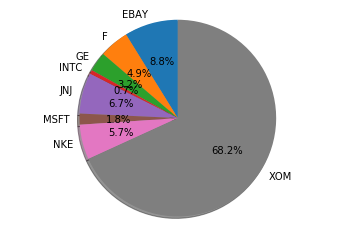



Год:  2004
Наиболее зависимые бумаги  F  и  EBAY , ковариация:  0.0001203
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,0.0001203,-1.52e-05,-1.6e-06,-3e-07,-1.97e-05,-9e-07,-1.84e-05
2,F,0.0001203,,-1.33e-05,2.17e-05,-2.1e-05,2.09e-05,5.5e-06,-1.59e-05
3,GE,-1.52e-05,-1.33e-05,,6.92e-05,2.53e-05,5.29e-05,3.66e-05,5.2e-05
4,INTC,-1.6e-06,2.17e-05,6.92e-05,,1.7e-05,9.42e-05,5.46e-05,3.11e-05
5,JNJ,-3e-07,-2.1e-05,2.53e-05,1.7e-05,,1.95e-05,1.13e-05,2.45e-05
6,MSFT,-1.97e-05,2.09e-05,5.29e-05,9.42e-05,1.95e-05,,3.2e-05,2.95e-05
7,NKE,-9e-07,5.5e-06,3.66e-05,5.46e-05,1.13e-05,3.2e-05,,2.97e-05
8,XOM,-1.84e-05,-1.59e-05,5.2e-05,3.11e-05,2.45e-05,2.95e-05,2.97e-05,


Доли эмитентов:  {'EBAY': 0.053577395081286394, 'F': 0.07400010165737915, 'GE': 0.06240763583737269, 'INTC': 0.018928437828115006, 'JNJ': 0.16083081664719057, 'MSFT': 0.07125353268754489, 'NKE': 0.08170215215535563, 'XOM': 0.4772999281057557}

Риск портфеля:  0.007500246886728102
Ожидаемая доходность портфеля:  0.0815124682332738


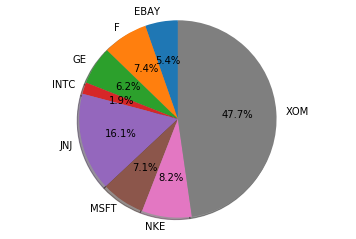

Доходность прошлогоднего портфеля:  9.84  %


Год:  2005
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  4.34e-05
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,9.9e-06,-7.4e-06,-1.83e-05,2.55e-05,-3.3e-06,-1e-06,-1.54e-05
2,F,9.9e-06,,-6.1e-06,3.24e-05,2.7e-06,2.21e-05,1.5e-05,3.02e-05
3,GE,-7.4e-06,-6.1e-06,,-1.4e-06,2.88e-05,-1.07e-05,2.99e-05,8e-07
4,INTC,-1.83e-05,3.24e-05,-1.4e-06,,-9.5e-06,4.34e-05,-1.84e-05,3.72e-05
5,JNJ,2.55e-05,2.7e-06,2.88e-05,-9.5e-06,,-4.3e-06,3.5e-06,-6.7e-06
6,MSFT,-3.3e-06,2.21e-05,-1.07e-05,4.34e-05,-4.3e-06,,-1.25e-05,2.95e-05
7,NKE,-1e-06,1.5e-05,2.99e-05,-1.84e-05,3.5e-06,-1.25e-05,,-4.7e-06
8,XOM,-1.54e-05,3.02e-05,8e-07,3.72e-05,-6.7e-06,2.95e-05,-4.7e-06,


Доли эмитентов:  {'EBAY': 0.022683384525365596, 'F': 0.0349048089363213, 'GE': 0.19640622103854444, 'INTC': 0.07275941115189316, 'JNJ': 0.20088162289047898, 'MSFT': 0.1779118146601929, 'NKE': 0.0976422983129836, 'XOM': 0.19681043848422006}

Риск портфеля:  0.006972136113807883
Ожидаемая доходность портфеля:  -0.008150592674715703


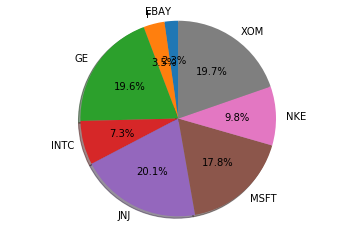

Доходность прошлогоднего портфеля:  -0.74  %


Год:  2006
Наиболее зависимые бумаги  INTC  и  F , ковариация:  0.000101
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,1.2e-05,2.4e-06,2.31e-05,-7.6e-06,1.89e-05,5.9e-06,1.05e-05
2,F,1.2e-05,,-1e-05,0.000101,9.8e-06,3.43e-05,1.3e-06,-6.6e-06
3,GE,2.4e-06,-1e-05,,1.01e-05,2.76e-05,-5.3e-06,1.51e-05,-9e-06
4,INTC,2.31e-05,0.000101,1.01e-05,,7.6e-06,6.58e-05,-3.8e-06,4.69e-05
5,JNJ,-7.6e-06,9.8e-06,2.76e-05,7.6e-06,,-1.9e-06,8e-06,-4.3e-06
6,MSFT,1.89e-05,3.43e-05,-5.3e-06,6.58e-05,-1.9e-06,,-1.45e-05,2.69e-05
7,NKE,5.9e-06,1.3e-06,1.51e-05,-3.8e-06,8e-06,-1.45e-05,,-1.13e-05
8,XOM,1.05e-05,-6.6e-06,-9e-06,4.69e-05,-4.3e-06,2.69e-05,-1.13e-05,


Доли эмитентов:  {'EBAY': 0.023132754850994093, 'F': 0.023860110855955467, 'GE': 0.19751726842833303, 'INTC': 0.021800733981171678, 'JNJ': 0.22802010596243827, 'MSFT': 0.06722175891191191, 'NKE': 0.14473730655929798, 'XOM': 0.2937099604498975}

Риск портфеля:  0.006489659353060043
Ожидаемая доходность портфеля:  0.05055618141699274


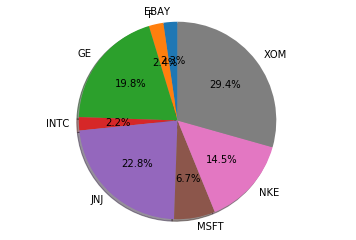

Доходность прошлогоднего портфеля:  3.54  %


Год:  2007
Наиболее зависимые бумаги  XOM  и  F , ковариация:  0.0001261
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,4.77e-05,-2.25e-05,7.3e-06,4.9e-06,-1e-06,-2.33e-05,1.43e-05
2,F,4.77e-05,,-8.8e-06,0.0001165,-9e-06,8.58e-05,-1.71e-05,0.0001261
3,GE,-2.25e-05,-8.8e-06,,-1.47e-05,3.85e-05,-1e-05,6.89e-05,-1.94e-05
4,INTC,7.3e-06,0.0001165,-1.47e-05,,1e-05,0.0001126,-3.2e-06,0.0001178
5,JNJ,4.9e-06,-9e-06,3.85e-05,1e-05,,-4.9e-06,3.52e-05,-5.8e-06
6,MSFT,-1e-06,8.58e-05,-1e-05,0.0001126,-4.9e-06,,-9.6e-06,0.0001062
7,NKE,-2.33e-05,-1.71e-05,6.89e-05,-3.2e-06,3.52e-05,-9.6e-06,,-6.2e-06
8,XOM,1.43e-05,0.0001261,-1.94e-05,0.0001178,-5.8e-06,0.0001062,-6.2e-06,


Доли эмитентов:  {'EBAY': 0.06273728822010122, 'F': 0.0220366935120439, 'GE': 0.13493131482947404, 'INTC': 0.02837756925969073, 'JNJ': 0.36964964898056407, 'MSFT': 0.06231892553994733, 'NKE': 0.07607435189953368, 'XOM': 0.2438742077586451}

Риск портфеля:  0.008012430250673056
Ожидаемая доходность портфеля:  0.044961174977305673


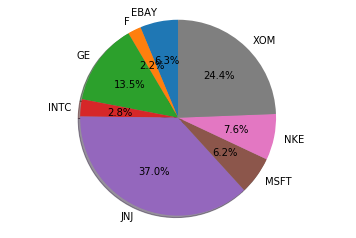

Доходность прошлогоднего портфеля:  5.37  %


Год:  2008
Наиболее зависимые бумаги  INTC  и  F , ковариация:  0.0009781
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,9.73e-05,4.12e-05,0.000201,4.9e-05,9.4e-05,-6.76e-05,0.000172
2,F,9.73e-05,,-5.44e-05,0.0009781,-2.59e-05,0.0008711,0.0001911,0.0006806
3,GE,4.12e-05,-5.44e-05,,-0.0001596,0.0003531,-7.76e-05,0.0006812,-0.0001161
4,INTC,0.000201,0.0009781,-0.0001596,,-0.0001442,0.0007494,-0.0001129,0.0006908
5,JNJ,4.9e-05,-2.59e-05,0.0003531,-0.0001442,,-8.49e-05,0.0003381,-9.44e-05
6,MSFT,9.4e-05,0.0008711,-7.76e-05,0.0007494,-8.49e-05,,-5.8e-05,0.0006746
7,NKE,-6.76e-05,0.0001911,0.0006812,-0.0001129,0.0003381,-5.8e-05,,-0.0001083
8,XOM,0.000172,0.0006806,-0.0001161,0.0006908,-9.44e-05,0.0006746,-0.0001083,


Доли эмитентов:  {'EBAY': 0.07752184151746937, 'F': 0.003212194278146627, 'GE': 0.06320590548581999, 'INTC': 0.04712745945136698, 'JNJ': 0.3472496917822877, 'MSFT': 0.05289581500630692, 'NKE': 0.08841935137458802, 'XOM': 0.3203677411040145}

Риск портфеля:  0.01915670577536133
Ожидаемая доходность портфеля:  -0.13493483906587908


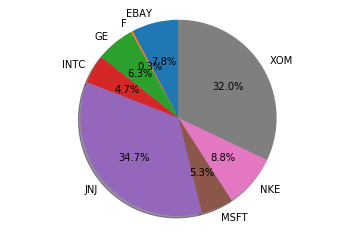

Доходность прошлогоднего портфеля:  -15.26  %


Год:  2009
Наиболее зависимые бумаги  INTC  и  F , ковариация:  0.0004247
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-4.47e-05,5.16e-05,-4.22e-05,3.42e-05,-4.55e-05,7.71e-05,-5.05e-05
2,F,-4.47e-05,,6.62e-05,0.0004247,1.13e-05,0.0003334,0.0001255,0.0001959
3,GE,5.16e-05,6.62e-05,,-4.81e-05,0.0001677,-8.44e-05,0.0003703,-6.66e-05
4,INTC,-4.22e-05,0.0004247,-4.81e-05,,-3.3e-06,0.000342,-4.33e-05,0.0002219
5,JNJ,3.42e-05,1.13e-05,0.0001677,-3.3e-06,,-2.01e-05,9.62e-05,4e-07
6,MSFT,-4.55e-05,0.0003334,-8.44e-05,0.000342,-2.01e-05,,-8.33e-05,0.0002069
7,NKE,7.71e-05,0.0001255,0.0003703,-4.33e-05,9.62e-05,-8.33e-05,,-6.89e-05
8,XOM,-5.05e-05,0.0001959,-6.66e-05,0.0002219,4e-07,0.0002069,-6.89e-05,


Доли эмитентов:  {'EBAY': 0.05926686898939683, 'F': 0.0026046524668871898, 'GE': 0.021603735734130446, 'INTC': 0.013047972436753949, 'JNJ': 0.30979712294945483, 'MSFT': 0.027374527505827223, 'NKE': 0.07999255996867316, 'XOM': 0.4863125599488764}

Риск портфеля:  0.011449314893456831
Ожидаемая доходность портфеля:  0.0232698683246266


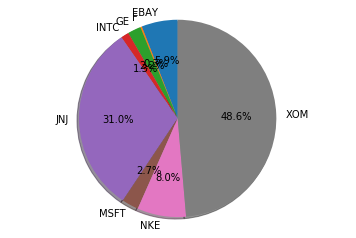

Доходность прошлогоднего портфеля:  4.51  %


Год:  2010
Наиболее зависимые бумаги  INTC  и  F , ковариация:  0.0002263
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-1.14e-05,-5.4e-06,-6.7e-06,7.5e-06,-2.4e-06,-6.8e-06,1.23e-05
2,F,-1.14e-05,,4.48e-05,0.0002263,4.5e-06,0.000176,7.8e-06,0.0001587
3,GE,-5.4e-06,4.48e-05,,-9.2e-06,7.82e-05,1.88e-05,0.0001538,-1.46e-05
4,INTC,-6.7e-06,0.0002263,-9.2e-06,,-5.2e-06,0.0001468,-6.6e-06,0.0001113
5,JNJ,7.5e-06,4.5e-06,7.82e-05,-5.2e-06,,1.1e-06,5.71e-05,-6.7e-06
6,MSFT,-2.4e-06,0.000176,1.88e-05,0.0001468,1.1e-06,,7.9e-06,9.88e-05
7,NKE,-6.8e-06,7.8e-06,0.0001538,-6.6e-06,5.71e-05,7.9e-06,,-4.1e-06
8,XOM,1.23e-05,0.0001587,-1.46e-05,0.0001113,-6.7e-06,9.88e-05,-4.1e-06,


Доли эмитентов:  {'EBAY': 0.05476140513369761, 'F': 0.0, 'GE': 0.042101893321988555, 'INTC': 0.014524434659616912, 'JNJ': 0.3040657931536433, 'MSFT': 0.021720658009740768, 'NKE': 0.07021545633272337, 'XOM': 0.4926103593885895}

Риск портфеля:  0.008071171695728671
Ожидаемая доходность портфеля:  0.02077390621890928


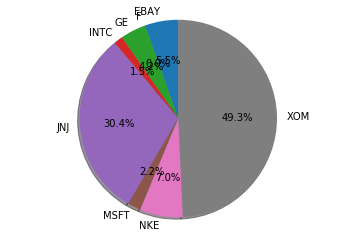

Доходность прошлогоднего портфеля:  2.09  %


Год:  2011
Наиболее зависимые бумаги  MSFT  и  F , ковариация:  0.0002594
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-2.31e-05,7.8e-06,-3.34e-05,5.8e-06,-3.58e-05,2.41e-05,-4.06e-05
2,F,-2.31e-05,,-2.33e-05,0.0002533,-1.86e-05,0.0002594,1.1e-06,0.0002538
3,GE,7.8e-06,-2.33e-05,,-2.1e-06,0.00014,-1.37e-05,0.0002118,-2.94e-05
4,INTC,-3.34e-05,0.0002533,-2.1e-06,,-1e-07,0.0001655,-1.02e-05,0.0001643
5,JNJ,5.8e-06,-1.86e-05,0.00014,-1e-07,,-1.59e-05,0.0001095,-2.19e-05
6,MSFT,-3.58e-05,0.0002594,-1.37e-05,0.0001655,-1.59e-05,,-2.65e-05,0.0001673
7,NKE,2.41e-05,1.1e-06,0.0002118,-1.02e-05,0.0001095,-2.65e-05,,-3.05e-05
8,XOM,-4.06e-05,0.0002538,-2.94e-05,0.0001643,-2.19e-05,0.0001673,-3.05e-05,


Доли эмитентов:  {'EBAY': 0.06503608455436626, 'F': 1.6263032587282567e-19, 'GE': 0.06304758819643991, 'INTC': 0.04119281426159653, 'JNJ': 0.287973845852234, 'MSFT': 0.06910961020245326, 'NKE': 0.07188763039902692, 'XOM': 0.40175242653388316}

Риск портфеля:  0.010444134365563022
Ожидаемая доходность портфеля:  0.03516958087476495


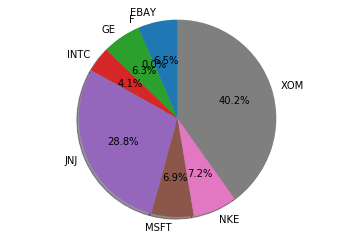

Доходность прошлогоднего портфеля:  4.04  %


Год:  2012
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  0.0001069
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-7.5e-06,-3e-06,-1.82e-05,-9e-07,-1.15e-05,-1e-06,-1.38e-05
2,F,-7.5e-06,,-2.6e-06,6.26e-05,-4.4e-06,7.88e-05,2.5e-05,6.5e-05
3,GE,-3e-06,-2.6e-06,,-1.31e-05,3.59e-05,5.1e-06,4.5e-05,2.4e-06
4,INTC,-1.82e-05,6.26e-05,-1.31e-05,,-3.5e-06,0.0001069,-2.74e-05,6.04e-05
5,JNJ,-9e-07,-4.4e-06,3.59e-05,-3.5e-06,,9e-07,1.49e-05,1.3e-06
6,MSFT,-1.15e-05,7.88e-05,5.1e-06,0.0001069,9e-07,,-1.4e-05,6.76e-05
7,NKE,-1e-06,2.5e-05,4.5e-05,-2.74e-05,1.49e-05,-1.4e-05,,-1.09e-05
8,XOM,-1.38e-05,6.5e-05,2.4e-06,6.04e-05,1.3e-06,6.76e-05,-1.09e-05,


Доли эмитентов:  {'EBAY': 0.042355818584417206, 'F': 0.012984551838931432, 'GE': 0.06227030152406579, 'INTC': 0.03175107885857324, 'JNJ': 0.3412237486634887, 'MSFT': 0.0149586796750211, 'NKE': 0.06009458885227213, 'XOM': 0.43436123200323046}

Риск портфеля:  0.0064026403061316845
Ожидаемая доходность портфеля:  0.02699639307326815


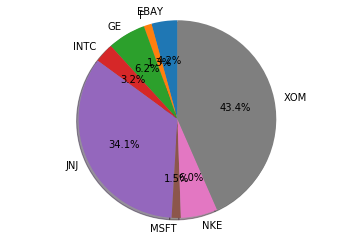

Доходность прошлогоднего портфеля:  3.0  %


Год:  2013
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  6.23e-05
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-8.1e-06,3.2e-06,-2.64e-05,-7.2e-06,-3.23e-05,2.5e-05,4.8e-06
2,F,-8.1e-06,,-3.3e-06,5.57e-05,8.4e-06,5.69e-05,7.4e-06,4.26e-05
3,GE,3.2e-06,-3.3e-06,,-1.64e-05,3.62e-05,1.6e-06,3.92e-05,-3.1e-06
4,INTC,-2.64e-05,5.57e-05,-1.64e-05,,-2.1e-06,6.23e-05,1.1e-06,3.84e-05
5,JNJ,-7.2e-06,8.4e-06,3.62e-05,-2.1e-06,,6.6e-06,3.88e-05,-9e-07
6,MSFT,-3.23e-05,5.69e-05,1.6e-06,6.23e-05,6.6e-06,,1.37e-05,3.07e-05
7,NKE,2.5e-05,7.4e-06,3.92e-05,1.1e-06,3.88e-05,1.37e-05,,-3.7e-06
8,XOM,4.8e-06,4.26e-05,-3.1e-06,3.84e-05,-9e-07,3.07e-05,-3.7e-06,


Доли эмитентов:  {'EBAY': 0.052187376812364634, 'F': 0.016090317959239674, 'GE': 0.08908673834562436, 'INTC': 0.04000599830903698, 'JNJ': 0.1861695114639851, 'MSFT': 0.026649120391816782, 'NKE': 0.06619472049846059, 'XOM': 0.523616216219472}

Риск портфеля:  0.006325655647765196
Ожидаемая доходность портфеля:  0.08247116006155658


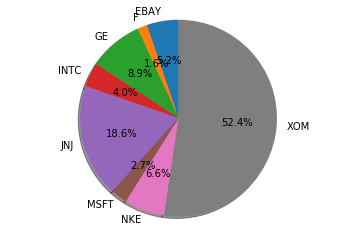

Доходность прошлогоднего портфеля:  8.74  %


Год:  2014
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  9.04e-05
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,8.8e-06,3.7e-06,-3.2e-06,5.2e-06,-1.3e-05,7.4e-06,-6e-07
2,F,8.8e-06,,2.8e-06,6.07e-05,7.6e-06,4.37e-05,-4.18e-05,5.47e-05
3,GE,3.7e-06,2.8e-06,,1.6e-06,4.39e-05,1.47e-05,4.67e-05,-7.2e-06
4,INTC,-3.2e-06,6.07e-05,1.6e-06,,-5.9e-06,9.04e-05,1.44e-05,5.13e-05
5,JNJ,5.2e-06,7.6e-06,4.39e-05,-5.9e-06,,7.5e-06,3.77e-05,-1.5e-06
6,MSFT,-1.3e-05,4.37e-05,1.47e-05,9.04e-05,7.5e-06,,1.58e-05,4.47e-05
7,NKE,7.4e-06,-4.18e-05,4.67e-05,1.44e-05,3.77e-05,1.58e-05,,-8.7e-06
8,XOM,-6e-07,5.47e-05,-7.2e-06,5.13e-05,-1.5e-06,4.47e-05,-8.7e-06,


Доли эмитентов:  {'EBAY': 0.08591968208568275, 'F': 0.0446524269144854, 'GE': 0.1503445776121915, 'INTC': 0.0349593543439057, 'JNJ': 0.15412104541886068, 'MSFT': 0.05173639022222511, 'NKE': 0.07240351276486255, 'XOM': 0.4058630106377864}

Риск портфеля:  0.006970378236941245
Ожидаемая доходность портфеля:  0.00714047594845987


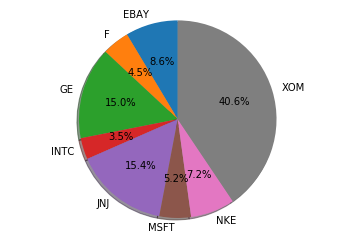

Доходность прошлогоднего портфеля:  0.37  %


Год:  2015
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  0.0001514
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-1.17e-05,7e-07,1.56e-05,-1.22e-05,1.4e-06,-1.31e-05,-1.68e-05
2,F,-1.17e-05,,1.15e-05,0.0001027,1.43e-05,0.0001196,1.4e-06,0.0001117
3,GE,7e-07,1.15e-05,,5.8e-06,8.09e-05,1.32e-05,7.92e-05,1.5e-06
4,INTC,1.56e-05,0.0001027,5.8e-06,,3.6e-06,0.0001514,-1.4e-06,0.0001116
5,JNJ,-1.22e-05,1.43e-05,8.09e-05,3.6e-06,,1.81e-05,7.37e-05,-6.3e-06
6,MSFT,1.4e-06,0.0001196,1.32e-05,0.0001514,1.81e-05,,-1.4e-06,0.0001109
7,NKE,-1.31e-05,1.4e-06,7.92e-05,-1.4e-06,7.37e-05,-1.4e-06,,1.7e-06
8,XOM,-1.68e-05,0.0001117,1.5e-06,0.0001116,-6.3e-06,0.0001109,1.7e-06,


Доли эмитентов:  {'EBAY': 0.10599807455436216, 'F': 0.0570635492751437, 'GE': 0.09465822201067256, 'INTC': 0.04275932443162269, 'JNJ': 0.22668894636228287, 'MSFT': 0.028636485252896665, 'NKE': 0.10043857885295379, 'XOM': 0.3437568192600656}

Риск портфеля:  0.009085945154915743
Ожидаемая доходность портфеля:  -0.0019856304732077225


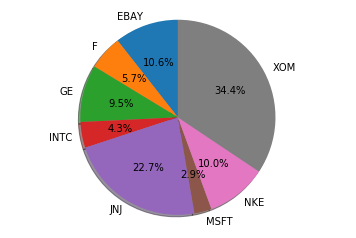

Доходность прошлогоднего портфеля:  -0.32  %


Год:  2016
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  0.0001249
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,1.07e-05,-1.14e-05,1.39e-05,-3.4e-06,6.1e-06,-4.6e-06,-1.65e-05
2,F,1.07e-05,,1.51e-05,0.0001071,-9.8e-06,9.37e-05,7e-06,6.72e-05
3,GE,-1.14e-05,1.51e-05,,5e-07,3.62e-05,-7e-07,6.54e-05,-1.9e-06
4,INTC,1.39e-05,0.0001071,5e-07,,1.3e-06,0.0001249,2.47e-05,6.44e-05
5,JNJ,-3.4e-06,-9.8e-06,3.62e-05,1.3e-06,,-2.2e-06,2.75e-05,-8.2e-06
6,MSFT,6.1e-06,9.37e-05,-7e-07,0.0001249,-2.2e-06,,1.44e-05,4.97e-05
7,NKE,-4.6e-06,7e-06,6.54e-05,2.47e-05,2.75e-05,1.44e-05,,2.3e-06
8,XOM,-1.65e-05,6.72e-05,-1.9e-06,6.44e-05,-8.2e-06,4.97e-05,2.3e-06,


Доли эмитентов:  {'EBAY': 0.058908884123160025, 'F': 0.026705874556824286, 'GE': 0.1288992831357621, 'INTC': 0.03191271338530113, 'JNJ': 0.270714827474747, 'MSFT': 0.05496042615403284, 'NKE': 0.06704688862703956, 'XOM': 0.36085110254313313}

Риск портфеля:  0.007638873732209764
Ожидаемая доходность портфеля:  0.03125703054343082


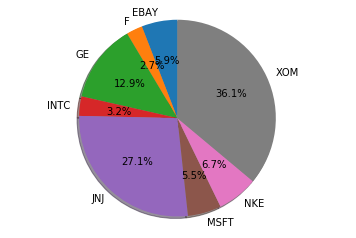

Доходность прошлогоднего портфеля:  2.46  %


Год:  2017
Наиболее зависимые бумаги  MSFT  и  INTC , ковариация:  4.87e-05
Матрица ковариаций


,0,1,2,3,4,5,6,7,8
0,0,EBAY,F,GE,INTC,JNJ,MSFT,NKE,XOM
1,EBAY,,-2e-06,1.12e-05,-4.7e-06,6.3e-06,-6.8e-06,1.58e-05,-6e-07
2,F,-2e-06,,5.9e-06,1.09e-05,-7e-07,2.8e-06,7.9e-06,2.02e-05
3,GE,1.12e-05,5.9e-06,,3e-06,5.7e-06,1.9e-06,1.43e-05,6.4e-06
4,INTC,-4.7e-06,1.09e-05,3e-06,,-5.4e-06,4.87e-05,2e-06,1.14e-05
5,JNJ,6.3e-06,-7e-07,5.7e-06,-5.4e-06,,-1.5e-06,9.7e-06,-2.5e-06
6,MSFT,-6.8e-06,2.8e-06,1.9e-06,4.87e-05,-1.5e-06,,-3.3e-06,6.6e-06
7,NKE,1.58e-05,7.9e-06,1.43e-05,2e-06,9.7e-06,-3.3e-06,,5.6e-06
8,XOM,-6e-07,2.02e-05,6.4e-06,1.14e-05,-2.5e-06,6.6e-06,5.6e-06,


Доли эмитентов:  {'EBAY': 0.060457817720722035, 'F': 0.04410714927068468, 'GE': 0.04241499631425269, 'INTC': 0.0515171321895953, 'JNJ': 0.18386673125073658, 'MSFT': 0.08738820731339014, 'NKE': 0.038650854373297586, 'XOM': 0.49159711156732105}

Риск портфеля:  0.005223143818987413
Ожидаемая доходность портфеля:  0.01427619393148374


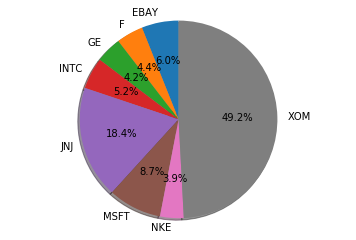

Доходность прошлогоднего портфеля:  0.0  %
Таблица доходностей портфелей по годам: 


,0
0.122386,2003
0.081512,2004
-0.008151,2005
0.050556,2006
0.044961,2007
-0.134935,2008
0.023270,2009
0.020774,2010
0.035170,2011
0.026996,2012


График доходностей портфелей минимального риска


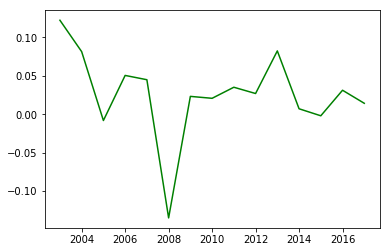

 Аналитический комментарий. На протяжении всего исследования можно было наблюдать сильную зависимостькомпаний Microsoft и Intel, это связано с тем, что они принадлежат одному сектору экономики. Стоит отметитьуникальное положение компаний Exxxon Mobil и Johnson & Johnson, в следствии того, что  у них нет конкурентовв данной выборке (а она является топом SP500 на 2003 год), это позволяло им, многие года занимать значительный объёмпортфеля. Примечательно также падение рынка 2008 года, что также ярко отразилось даже на нашем, консервативном портфеле
 Дамир Павлин. 2018, г. Москва.


In [11]:
names = ['Ebay', 'Ford Company', 'General Electrics', 'Intel', 'Johnson & Johnson', 'Microsoft', 'Nike', 'Exxxon Mobil']
stockNames = ['EBAY', 'F', 'GE', 'INTC', 'JNJ', 'MSFT', 'NKE', 'XOM' ]
allNames = pd.DataFrame(names, stockNames)
display(allNames)

grabber = [] #грязный грэббер
histYields = [] #пустой массив для исторических доходностей
weightPreviousStocks = {} #пустой словарь для предыдущих лет

for i in range(15):
    histYields.append(0)

grabber = MarkowitzPavlin(2003, 0)    #первый запуск
histYields[0] = grabber[1]
weightPreviousStocks = grabber[0]

for i in range(2004, 2018):
    grabber = []
    grabber = MarkowitzPavlin(i, weightPreviousStocks)
    histYields[i-2003] = grabber[1]
    weightPreviousStocks = {}
    weightPreviousStocks = grabber[0]


y = histYields #построение графика доходностей
x = []
for i in range (2003, 2018):
    x.append(i)
dfHistYields = pd.DataFrame(x, y)
print ("Таблица доходностей портфелей по годам: ")
display(dfHistYields)
plt.plot(x, y, color="green")
print ("График доходностей портфелей минимального риска")
plt.show()
print (" Аналитический комментарий. На протяжении всего исследования можно было наблюдать сильную зависимость\
компаний Microsoft и Intel, это связано с тем, что они принадлежат одному сектору экономики. Стоит отметить\
уникальное положение компаний Exxxon Mobil и Johnson & Johnson, в следствии того, что  у них нет конкурентов\
в данной выборке (а она является топом SP500 на 2003 год), это позволяло им, многие года занимать значительный объём\
портфеля. Примечательно также падение рынка 2008 года, что также ярко отразилось даже на нашем, консервативном портфеле\
\n Дамир Павлин. 2018, г. Москва.")
    
    